<a href="https://colab.research.google.com/github/taslimmirza/DeepFER/blob/main/DeepFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, GlobalAveragePooling2D

# Defining parameter

In [ ]:
train_dir = 'images/train/'
validation_dir = 'images/validation/'

batch_size = 64
image_size = (48, 48)
n_classes = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# Dataset Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

validation_datagen  = ImageDataGenerator(rescale = 1./255)

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = image_size,
                                                   class_mode = 'categorical',
                                                   batch_size = batch_size)

validation_dataset = validation_datagen.flow_from_directory(directory = validation_dir,
                                                  target_size = image_size,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = batch_size)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Sample Occurance

In [ ]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(validation_dir, 'test')

HTML(train_count._append(test_count).to_html(escape=False))

,angry,disgust,fear,happy,neutral,sad,surprise
train,3993,436,4103,7164,4982,4938,3205
test,960,111,1018,1825,1216,1139,797


# Plotting sample occurance

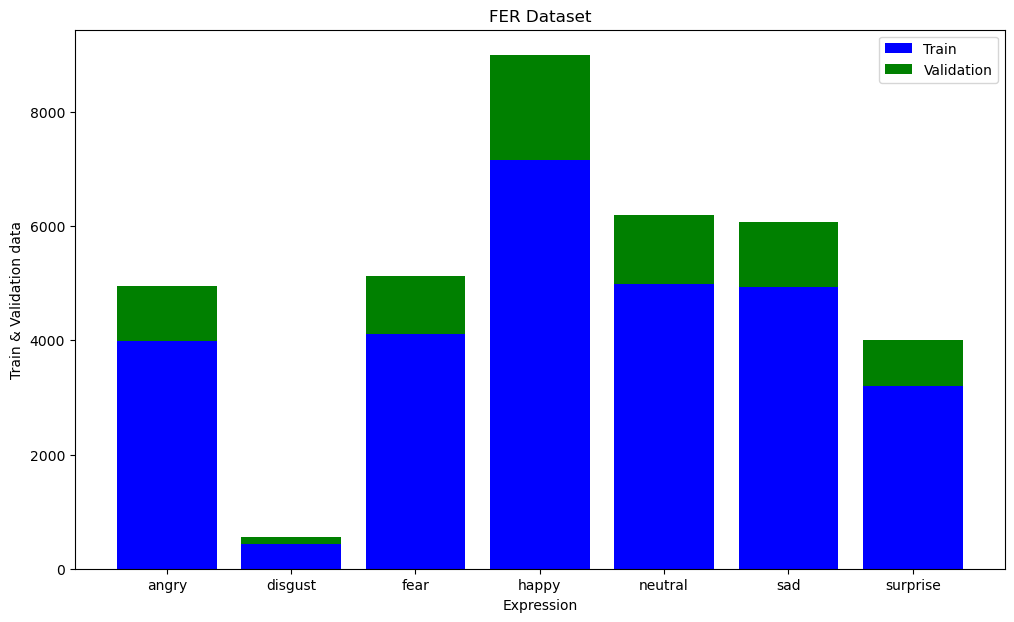

In [ ]:
x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='green')
plt.xlabel("Expression")
plt.ylabel("Train & Validation data")
plt.legend(["Train", "Validation"], loc='upper right')
plt.title("FER Dataset")
plt.savefig('samples_frequency.png')
plt.show()

# Displaying sample from each class

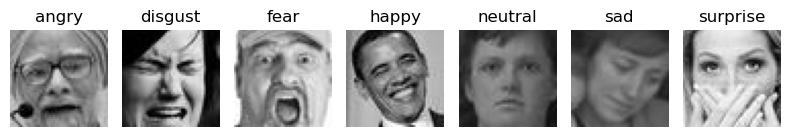

In [ ]:
plt.figure(figsize=(8,15))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.tight_layout()
plt.savefig('samples.png')
plt.show()

# Calculating class weights

In [ ]:
counter = Counter(train_dataset.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}

print("Class Weights:", class_weights)

Class Weights: {0: 1.79, 1: 16.43, 2: 1.75, 3: 1.0, 4: 1.44, 5: 1.45, 6: 2.24}


# Loading base model

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape= image_size+(3,) ,include_top=False, weights="imagenet")
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

# Freezing base model

In [ ]:
for layer in base_model.layers[:11]:
    layer.trainable=False

print("Model trainable",len(base_model.trainable_variables))

Model trainable 12


# Defining transfer learning model

In [ ]:
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

# Compiling model

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

# Model Training

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5', save_best_only=True, mode='max')
es = EarlyStopping(verbose=1, patience=10)

history=model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs = 100,
                  verbose =1,
                  callbacks = [lrd,mcp,es],
                  class_weight = class_weights)


Epoch 1/100
451/451 [==============================] - 23s 44ms/step - loss: 5.1828 - accuracy: 0.8163 - precision: 0.2087 - recall: 0.1023 - auc: 0.5589 - f1_score: 0.1370 - val_loss: 23.6584 - val_accuracy: 0.7465 - val_precision: 0.1128 - val_recall: 0.1128 - val_auc: 0.4824 - val_f1_score: 0.1126 - lr: 1.0000e-04
Epoch 2/100
451/451 [==============================] - 20s 44ms/step - loss: 4.5085 - accuracy: 0.8324 - precision: 0.3008 - recall: 0.1310 - auc: 0.6198 - f1_score: 0.1817 - val_loss: 5.3324 - val_accuracy: 0.7512 - val_precision: 0.1173 - val_recall: 0.1136 - val_auc: 0.5379 - val_f1_score: 0.1152 - lr: 1.0000e-04
Epoch 3/100
451/451 [==============================] - 19s 43ms/step - loss: 4.0397 - accuracy: 0.8440 - precision: 0.3952 - recall: 0.1734 - auc: 0.6779 - f1_score: 0.2406 - val_loss: 3.6123 - val_accuracy: 0.8307 - val_precision: 0.3953 - val_recall: 0.3498 - val_auc: 0.6864 - val_f1_score: 0.3716 - lr: 1.0000e-04
Epoch 4/100
451/451 [========================

# Model Evaluation

In [ ]:
train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(validation_dataset)

metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list,
                           [round(num, 3) for num in train_evalation],
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))


111/111 [==============================] - 2s 17ms/step - loss: 1.2042 - accuracy: 0.9030 - precision: 0.6920 - recall: 0.5790 - auc: 0.9076 - f1_score: 0.6304


Model Scores



,Metric Name,Train,Validate
0,Loss,0.603,1.204
1,Accuracy,0.949,0.903
2,Precision,0.870,0.692
3,Recall,0.757,0.579
4,Auc,0.976,0.908
5,F1_Score,0.809,0.630


# Visualizing results

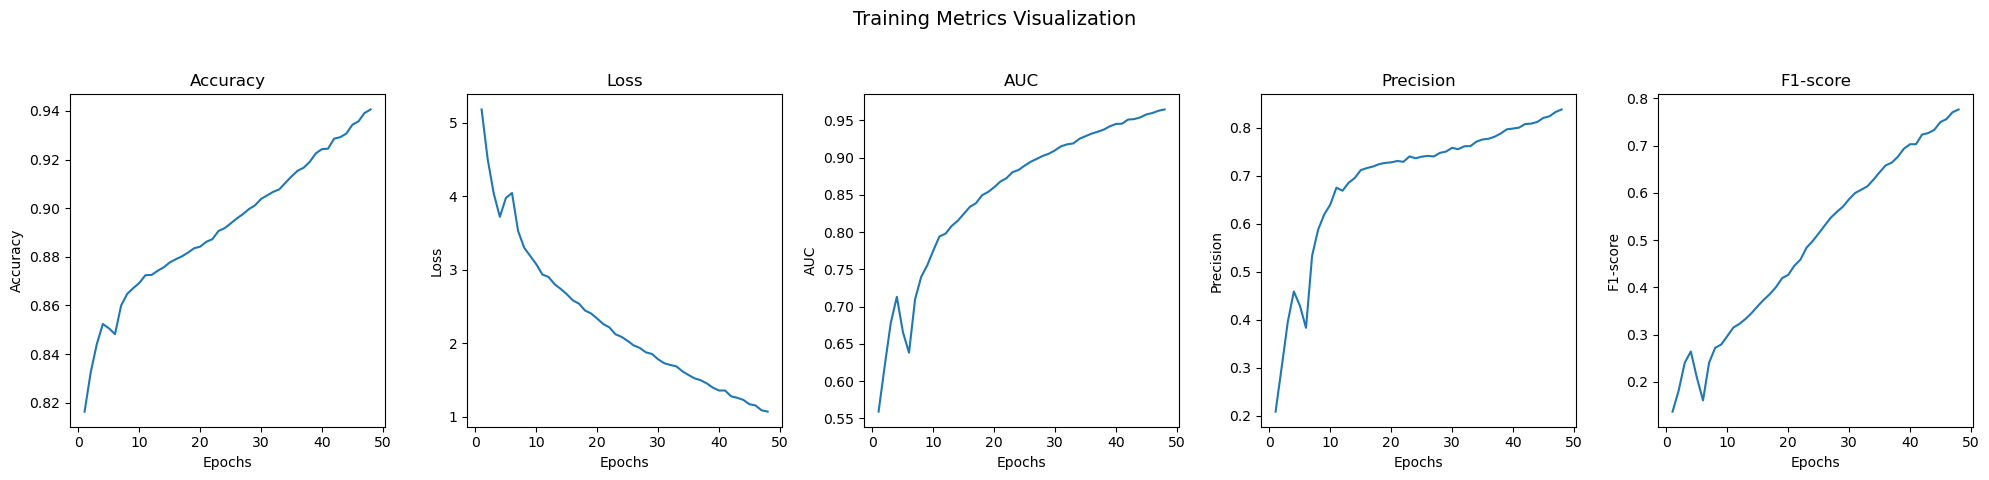

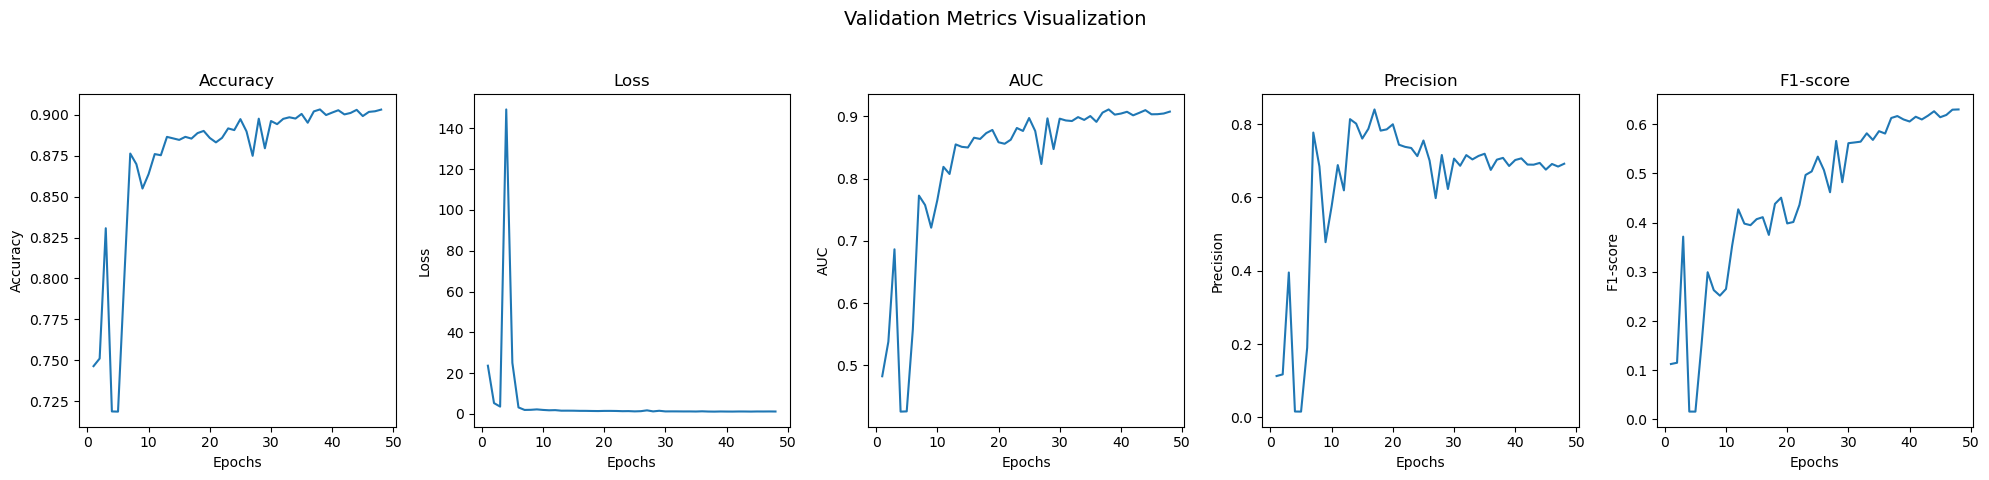

In [ ]:

hs = history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss = hs['loss']
val_loss = hs['val_loss']
auc = hs['auc']
val_auc = hs['val_auc']
precision = hs['precision']
val_precision = hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']


fig_train, axes_train = plt.subplots(1, 5, figsize=(20, 5))
fig_train.suptitle("Training Metrics Visualization", fontsize=14)

metrics = [('Accuracy', acc), ('Loss', loss), ('AUC', auc), ('Precision', precision), ('F1-score', f1)]
for ax, (metric_name, train_metric) in zip(axes_train, metrics):
    ax.plot(range(1, len(train_metric) + 1), train_metric)
    ax.set_title(f'{metric_name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('training_results.png')
plt.show()

fig_val, axes_val = plt.subplots(1, 5, figsize=(20, 5))
fig_val.suptitle("Validation Metrics Visualization", fontsize=14)

metrics = [('Accuracy', val_acc), ('Loss', val_loss), ('AUC', val_auc), ('Precision', val_precision), ('F1-score', val_f1)]
for ax, (metric_name, val_metric) in zip(axes_val, metrics):
    ax.plot(range(1, len(val_metric) + 1), val_metric)
    ax.set_title(f'{metric_name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('validation_results.png')
plt.show()

# Confusion Matrix

111/111 [==============================] - 2s 17ms/step


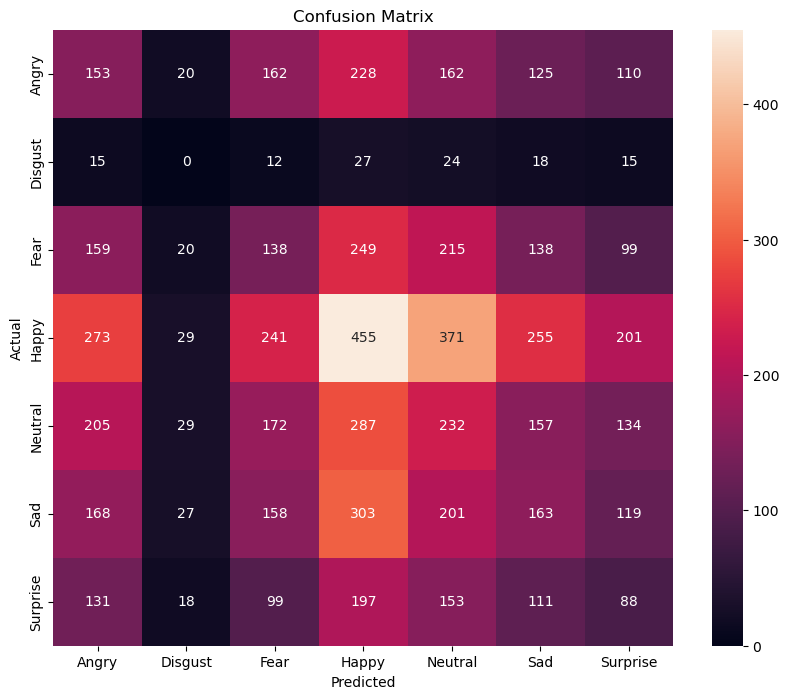

In [ ]:
y_true = validation_dataset.classes
y_pred =  model.predict(validation_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=n_classes, yticklabels=n_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_metrix.png')
plt.show()

# Saving Model

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Prediction on image

(48, 48, 1)


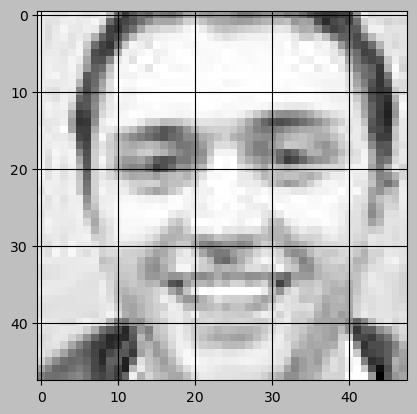

In [ ]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='images/validation/happy/30.jpg'
test_image=image.load_img(img_path,target_size= image_size,color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

In [ ]:
img=image.load_img(img_path,target_size=image_size)
img = np.expand_dims(img, axis=0)
print(img.shape)
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',n_classes[y_pred])

(1, 48, 48, 3)
1/1 [==============================] - 0s 287ms/step
[0. 0. 0. 1. 0. 0. 0.]
The person facial emotion is: Happy
